<div style= "background-color: #f8f9fa; color: #333; padding: 15px;">
    <a class="anchor" id="1st-bullet"></a>
    <h3 style="color: #198754;font-weight: bold;">DATA MINING GROUP PROJECT</h3>
    <h2 style="color: #198754; font-weight: bold;">ABCDEats Inc. Final Report - 2. Clustering</h3>
    <h3 style="color: #198754;">Group 20</h3>
    Afonso Gamito, 20240752 <br>
    Gonçalo Pacheco, 20240695<br>
    Hassan Bhatti, 20241023<br>
    Moeko Mitani, 20240670 <br>
</div>

# Index

- [Importing the Libraries and CVS file](#1) 
- [1. Splitting The Features](#2)
- [2. Hierarchical Clustering](#3)
    - [2.1. Defining The Linkage Method and Performing Clustering](#4)
    - [2.2. Categorizing The Clusters](#5)
    - [2.3. Calculating SST, SSW, and SSB](#6)
    - [2.4. Defining The Number of Clusters](#7)
    - [2.5. Test Cluster Solutions](#8)
    - [2.6. Final Hierarchical Clustering Solution](#9)
    - [2.7. Visualize The Cluster Means as a Heatmap](#10)
    - [2.8. Compare The Cluster Means to The Population Means](#11)
    - [2.9. Visualize The Cluster Means with The Cluster Sizes](#12)
- [3. K-Means Clustering](#13) 
    - [3.1. Defining The Number of Clusters](#14)
    - [3.2. Inertia Values to Visualize The "Elbow" Point (Optimal Number of Clusters)](#15)
    - [3.3. Average Silhouette Score Against The Mumber of Clusters](#16)
    - [3.4. Final K-Means Clustering Solution with 3 Clusters](#17)
- [4. Clustering by Perspectives](#18)
    - [4.1. Testing on K-means Clustering and Hierarchical Clustering](#19)
    - [4.2. Finding The Optimal Clusterer on Behavior Variables](#20)
    - [4.3. Finding The Optimal Clusterer on Value Variables](#21)
    - [4.4. Merging the Perspectives](#22)
    - [4.5. Manual Merging: Merge Lowest Frequency Clusters into Closest Clusters](#23)
    - [4.6. Merging Using Hierarchical Clustering](#24)
- [5. Cluster Analysis](#25)
    - [5.1. Profiling with Unused / Categorical Features](#26)
    - [5.2. Cluster visualization using t-SNE](#27)

# Acknowledgement

In this project, we got help from ChatGPT with some python codes.

<a class="anchor" id="1">     

# Importing the Libraries and CVS file

</a>    

In [2]:
# Import essential libraries
## os: For file path manipulations
## numpy, pandas: For numerical computations and data manipulation
import os  
import numpy as np
import pandas as pd  
from os.path import join  

# Import visualization libraries
## seaborn, matplotlib: For data visualization and better interpretability
## sklearn.manifold.TSNE: For dimensionality reduction and visualization of high-dimensional data
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE 

# Import clustering and evaluation libraries
## Hierarchical and K-Means clustering: Common clustering techniques in data mining
## silhouette metrics: To evaluate cluster quality and cohesion
## pairwise_distances: For distance calculations in clustering
from scipy.cluster.hierarchy import dendrogram 
from sklearn.cluster import AgglomerativeClustering, KMeans  
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances   

# Mathematical utilities
## ceil: For rounding up values during mathematical operations
from math import ceil  

# Model-related libraries
## itertools.product: For generating combinations during parameter tuning
## sklearn.base.clone: For creating deep copies of models
## train_test_split: For splitting data into training and testing sets
## DecisionTreeClassifier, export_graphviz: For creating decision trees and visualizing them
from itertools import product
from sklearn.base import clone  
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz


# Set Seaborn's default theme for consistent and visually appealing plots
sns.set()

# Suppress warnings for cleaner outputs during analysis
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the preprocessed dataset
# The dataset is cleared from all pre-processing steps, and ready
# To perform clustering upon

file_path = 'project_data/preprocessed_dataset.csv'
df = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the dataset to verify successful loading
df.head()

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,afternoon_orders,evening_orders,customer_frequency,customer_preference,weekend_orders
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,0.000000,0.066667,Infrequent,CUI_Indian,0.08
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,0.027027,0.000000,Infrequent,CUI_Indian,0.04
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,0.000000,0.000000,Infrequent,CUI_Asian,0.04


In [5]:
# Display the column names in one list to verify sucessful loading
df.columns

Index(['customer_id', 'vendor_count', 'is_chain', 'payment_method',
       'days_as_customer', 'money_spent', 'customer_city', 'total_orders',
       'age_group', 'morning_orders', 'afternoon_orders', 'evening_orders',
       'customer_frequency', 'customer_preference', 'weekend_orders'],
      dtype='object')

<a class="anchor" id="2">     

# 1. Splitting The Features

</a>    

In [6]:
# Split features into categories for better organization

# Numerical Features: Continuous variables representing metrics for analysis
metric_features = [
    'vendor_count',
    'days_as_customer',
    'money_spent',
    'total_orders',
    'morning_orders',
    'afternoon_orders',
    'evening_orders',
    'weekend_orders'
 ]

# Categorical Features: Discrete variables representing groups or categories
non_metric_features = [
    'is_chain',
    'payment_method',
    'customer_city',
    'age_group',
    'customer_frequency',
    'customer_preference',
]

# Unused Features: Identifying features not used in the analysis
## This ensures transparency in feature selection and highlights columns excluded from clustering
unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features) ]

In [7]:
# Display the categorized features to confirm correctness
print('metric_features:', metric_features)
print('non_metric_features:', non_metric_features)
print('unused_features:', unused_features)

metric_features: ['vendor_count', 'days_as_customer', 'money_spent', 'total_orders', 'morning_orders', 'afternoon_orders', 'evening_orders', 'weekend_orders']
non_metric_features: ['is_chain', 'payment_method', 'customer_city', 'age_group', 'customer_frequency', 'customer_preference']
unused_features: ['customer_id']


<a class="anchor" id="3">     

# 2. Hierarchical Clustering

</a>    

<a class="anchor" id="4">     

## 2.1. Defining The Linkage Method and Performing Clustering

</a>    

The linkage method is set to 'ward' with the Euclidean metric. This choice minimizes variance within clusters and is suitable for continuous data. Ensure you test multiple linkage methods to verify the robustness of your results.

In [8]:
# Use Ward's method with Euclidean distance
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5) 
# Fit the model and predict cluster labels
hc_labels = hclust.fit_predict(df[metric_features]) 
hc_labels

array([4, 4, 4, ..., 4, 4, 4])

<a class="anchor" id="5">     

## 2.2. Categorizing The Clusters

</a>    

In [9]:
labels_series = pd.Series(hc_labels, 
                          name='labels', 
                          index=df.index # To maintain data integrity, we put df.index
                          ) 

df_concat = pd.concat([df, labels_series],axis=1)

# Group by cluster labels and calculate the mean for each feature
df_concat[metric_features+['labels']].groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.147717,0.662741,0.045571,0.043433,0.025789,0.049649,0.024762,0.047375
1,0.814815,0.862039,0.178057,0.259971,0.127170,0.224313,0.160110,0.237992
2,0.387635,0.800983,0.098647,0.114234,0.058739,0.103376,0.068780,0.110884
3,0.119270,0.327451,0.035665,0.029379,0.019532,0.034000,0.020794,0.037564
4,0.032025,0.032537,0.022152,0.007277,0.009664,0.016104,0.009288,0.016610


Using **df.index** ensures the cluster labels align with the original DataFrame indices, This is crucial to preserving data integrity. Once, the labels and the original data are concatenated for analysis, we finally group by cluster labels and computed means.

<a class="anchor" id="6">     

## 2.3. Calculating SST, SSW, and SSB

</a>    

In [10]:
# SST (Sum of Squares Total)
x_i = df_concat[metric_features]
# Mean of the entire dataset for each feature
x_mean = df_concat[metric_features].mean() 

# Total sum of squares
sst_sum = np.sum(np.sum(np.square(x_i - x_mean), axis=0), axis=0) 
sst_sum

np.float64(5355.039596278378)

This calculates the total variance in the data. Ensure **metric_features** includes only numeric columns to avoid unintended errors.

In [11]:
# SSB (Sum of Sqares Between)

# Initialize between-group sum of squares
ssb_sum = 0 

# Mean of the entire dataset for each feature
x_mean = df_concat[metric_features].mean()

# Loop through each unique cluster label
for i in df_concat['labels'].unique(): 
    # Subset of data for the current cluster
    df_k = df_concat.loc[df_concat['labels']==i, metric_features] 
    n_k = df_k.shape[0] 
    # Mean of the current cluster
    x_k = df_k.mean()
    # Calculate SSB (variance between clusters)
    ssb_sum += (n_k * np.square((x_k - x_mean))) 

# Total sum of squares between-group
ssb_sum = ssb_sum.sum()
ssb_sum

np.float64(4325.870054001923)

In [12]:
# SSW (Sum of Sqares Within)

# Initialize within-group sum of squares
ssw_sum = 0 

# Loop through each unique cluster label
for i in df_concat['labels'].unique(): 
    # Subset of data for the current cluster
    df_k = df_concat.loc[df_concat['labels']==i, metric_features] 
    # Mean of the current cluster
    x_k = df_k.mean() 
    # Calculate SSW (variance within clusters)
    ssw_sum += (np.sum(np.square(df_k - x_k ), axis=0)) 

# Total sum of squares between-group
ssw_sum = np.sum(ssw_sum, axis=0) 
ssw_sum

np.float64(1029.169542276456)

In [13]:
# Verify the results
sst_sum == ssw_sum + ssb_sum

np.False_

In [14]:
# Calculate the sum of squares (SS)
def get_ss(df, feats):
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 

# Calculate the between-group sum of squares (SSB)
def get_ssb(df, feats, label_col):  
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


# Calculate the sum of squared within-cluster distances (SSW)
def get_ssw(df, feats, label_col):
    feats_label = feats + [label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats))

    return df_k.sum()


In [15]:
df_sst_ = get_ss(df_concat, metric_features)
df_ssb_ = get_ssb(df_concat, metric_features, 'labels')
df_ssw_ = get_ssw(df_concat, metric_features, 'labels')

print("SSB:  ", df_ssb_)
print("SSW:  ", df_ssw_)
print("SST:  ", df_sst_)
print("STt == SSB+SSW ? ", (df_sst_ == df_ssb_ + df_ssw_))


SSB:   4325.870054001923
SSW:   1029.169542276456
SST:   5355.039596278378
STt == SSB+SSW ?  False


In [16]:
# Calculate the R-squared value
def get_rsq(df, feats, label_col):
    # Get total sum of squares
    df_sst_ = get_ss(df, feats)        
    # Get ss within         
    df_ssw_ = get_ssw(df, feats, label_col)   
    # Get ss between  
    df_ssb_ = df_sst_ - df_ssw_                 

    # R2 = SSB/SST
    return (df_ssb_/df_sst_)

In [17]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    
    r2 = []  # Where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    # Iterate over desired ncluster range
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        # Get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # Concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # Append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [18]:
##########################################
# THIS TAKES A FEW MINUTES TO RUN!!
##########################################

#Calculate R-squared for different linkage methods

#List of hierarchical clustering linkage methods to evaluate
hc_methods = ["ward", "complete", "average", "single"]

#Maximum number of clusters to consider for the R-squared calculation
max_nclus = 10 

#Compute R-squared values for each linkage method
r2_hc = np.vstack([ get_r2_hc(df[metric_features], 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") # Distance metric used for clustering
                              for link in hc_methods])

In [19]:
#Create a DataFrame to organize R-squared values for each linkage method
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

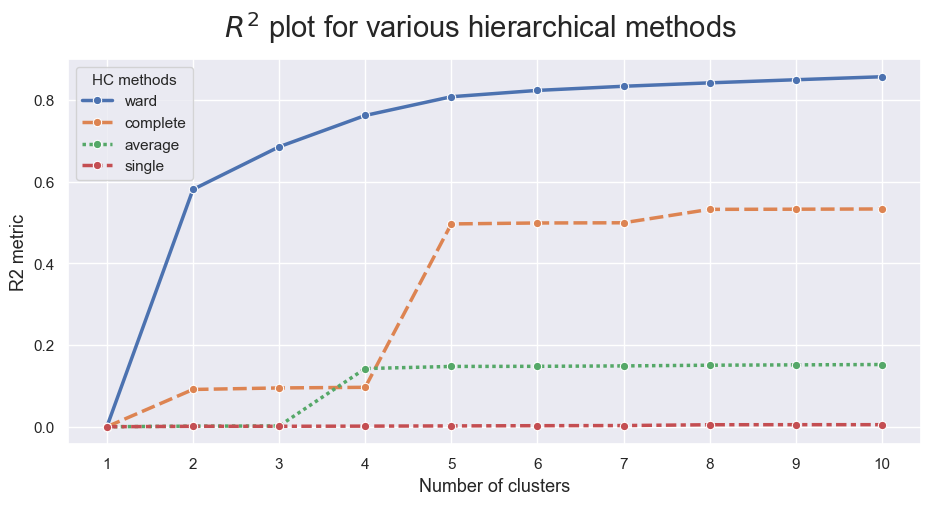

In [20]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

As you can see from this graph, the best linkage technique for hierachical clustering in our project was ward, leading to that being our choice moving foreward. 

<a class="anchor" id="7">     

## 2.4. Defining The Number of Clusters

</a>  

In [21]:
# Ward's method minimizes the variance of merged clusters
linkage = 'ward' 
# Euclidean distance is commonly used for continuous numerical data
distance = 'euclidean' 

# Set distance_threshold=0 and n_clusters=None ensures we compute the full tree
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)

# The `fit_predict` method assigns each data point to a cluster based on the hierarchical structure
hclust.fit_predict(df[metric_features])

array([20636, 28496, 19386, ...,     5,     2,     0])

In [22]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # Track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# The hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# The hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# The counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



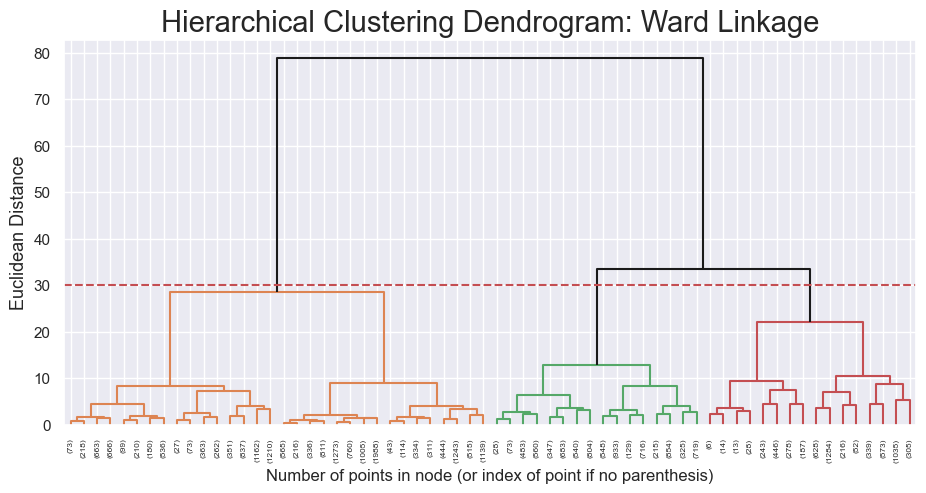

In [23]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

As you can see from this graph that the optimal place to draw the line, is before 3 clusters, leading that to be our choice for the final solution calculations.

<a class="anchor" id="8">     

## 2.5. Test Cluster Solutions

</a>  


Just to be sure, we decided to consider 2 clusters at first, and compare the results with 3 clusters more closely

In [24]:
# 2 cluster solution
n_clusters = 2

hc2_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc2_labels = hc2_clust.fit_predict(df[metric_features])

In [25]:
# Characterize the 2 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc2_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.285459,0.725578,0.074695,0.085838,0.045578,0.082752,0.051191,0.085090
1,0.065564,0.145909,0.027347,0.015774,0.013458,0.022984,0.013711,0.024665


In [26]:
# 3 cluster solution
n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc3_labels = hc3_clust.fit_predict(df[metric_features])

In [27]:
# Characterize the 3 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc3_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.065564,0.145909,0.027347,0.015774,0.013458,0.022984,0.013711,0.024665
1,0.479547,0.814120,0.115733,0.145590,0.073463,0.129397,0.088430,0.138233
2,0.147717,0.662741,0.045571,0.043433,0.025789,0.049649,0.024762,0.047375


In [28]:
pd.crosstab(
    pd.Series(hc3_labels, name='hc3_labels', index=df.index),
    pd.Series(hc2_labels, name='hc2_labels', index=df.index),
    )

hc2_labels,0,1
hc3_labels,,
0,0,18027
1,5647,0
2,7957,0


In the end, 3 clusters had a better solution leading to that being our choice for the Final hierarchical clustering solution

<a class="anchor" id="9">     

## 2.6. Final Hierarchical Clustering Solution

</a>  


In [29]:
# Final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 3

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df[metric_features])

In [30]:
# Characterize the final clusters

df_concat = pd.concat([
    df[metric_features], 
    pd.Series(hc_labels, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.065564,0.145909,0.027347,0.015774,0.013458,0.022984,0.013711,0.024665
1,0.479547,0.814120,0.115733,0.145590,0.073463,0.129397,0.088430,0.138233
2,0.147717,0.662741,0.045571,0.043433,0.025789,0.049649,0.024762,0.047375


<a class="anchor" id="10">     

## 2.7. Visualize The Cluster Means as a Heatmap

</a>  


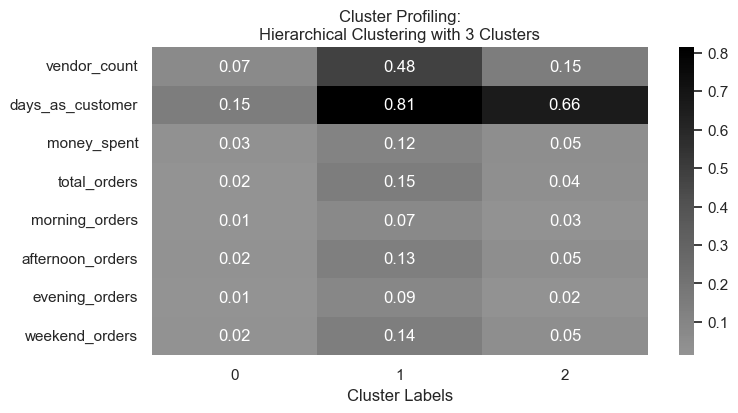

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="Greys", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

<a class="anchor" id="11">     

## 2.8. Compare The Cluster Means to The Population Means

</a>  


In [32]:
hc_profile = df_concat.groupby('labels').mean().T

df_means = df_concat[metric_features].mean()
df_means.name="Data"


pd.concat([hc_profile, 
           df_means], axis=1
)

,0,1,2,Data
vendor_count,0.065564,0.479547,0.147717,0.160137
days_as_customer,0.145909,0.814120,0.662741,0.395216
money_spent,0.027347,0.115733,0.045571,0.047710
total_orders,0.015774,0.145590,0.043433,0.045907
morning_orders,0.013458,0.073463,0.025789,0.027272
afternoon_orders,0.022984,0.129397,0.049649,0.048689
evening_orders,0.013711,0.088430,0.024762,0.029830
weekend_orders,0.024665,0.138233,0.047375,0.050653


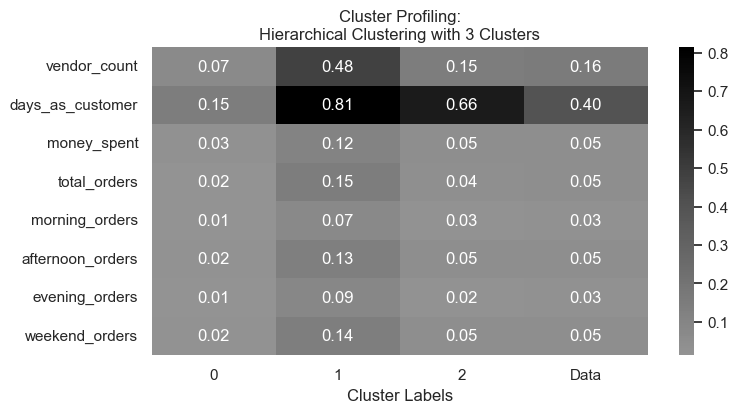

In [33]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

df_means = df_concat[metric_features].mean()
df_means.name="Data"


hc_profile = pd.concat([hc_profile, 
                        df_means], axis=1
                        )

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="Greys", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

<a class="anchor" id="12">     

## 2.9. Visualize The Cluster Means with The Cluster Sizes

</a>  


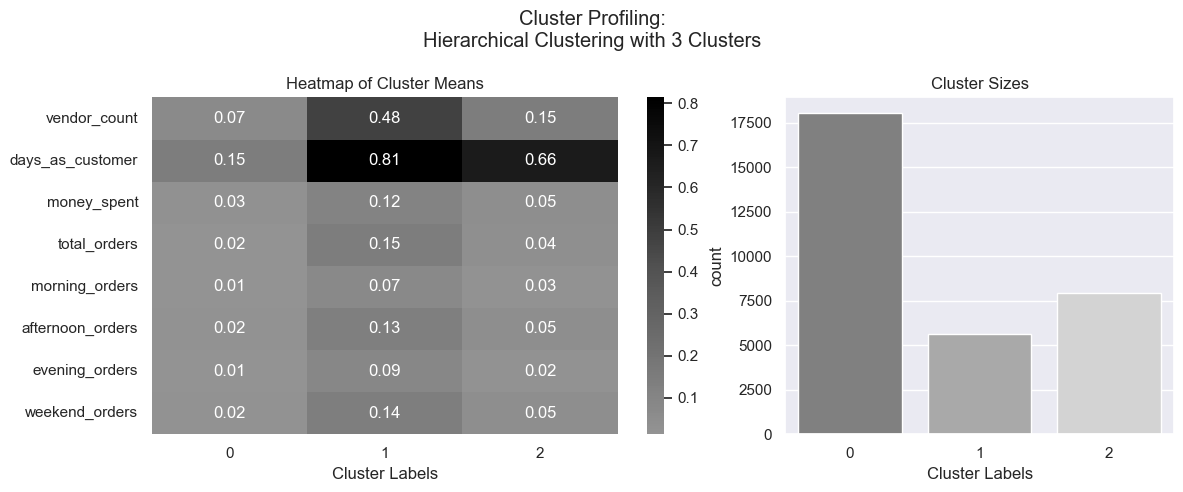

In [34]:
label_counts = None 

fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[0.6, 0.4], tight_layout=True)

hc_profile = df_concat.groupby('labels').mean().T

# Adjust the heatmap color scheme to greyscale
sns.heatmap(hc_profile,
            center=0, annot=True, cmap="Greys", fmt=".2f",
            ax=axes[0]
            )
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")

# Adjust the countplot to use grey shades
sns.countplot(df_concat, x='labels', ax=axes[1], palette=["#808080", "#A9A9A9", "#D3D3D3"])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()


<a class="anchor" id="13">     

# 3. K-Means Clustering

</a>  


In [35]:
# 8 clusters, random initialization, 10 initializations, and a random seed for reproducibility
kmclust = KMeans(n_clusters=8, init='random', n_init=10, random_state=1)

In [36]:
# Fit the model on the dataset
kmclust.fit(df[metric_features])

KMeans(init='random', n_init=10, random_state=1)

In [37]:
# Predict the cluster labels for the data points
kmclust.predict(df[metric_features])

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

In [38]:
# Transform the data by calculating the distance of each point
# To each cluster center
pd.DataFrame(kmclust.transform(df[metric_features]))

,0,1,2,3,4,5,6,7
0,0.960613,0.835276,0.383568,0.648169,0.602784,0.110497,1.285374,0.186824
1,0.962596,0.835146,0.382067,0.649556,0.601904,0.099373,1.290271,0.182746
2,0.999371,0.848935,0.398868,0.690111,0.613073,0.079665,1.340689,0.209116
3,0.952134,0.822069,0.366096,0.638626,0.587642,0.074427,1.284731,0.161086
4,0.952597,0.823635,0.370051,0.639443,0.590127,0.093565,1.283905,0.169603
...,...,...,...,...,...,...,...,...
31626,1.018566,0.863197,0.409762,0.707081,0.624705,0.042103,1.367113,0.216199
31627,1.017592,0.862165,0.408606,0.706567,0.623803,0.034078,1.366482,0.214466
31628,1.015013,0.860799,0.407202,0.704120,0.622761,0.030415,1.362627,0.212273
31629,1.015133,0.860852,0.407233,0.704226,0.622788,0.030030,1.362821,0.212307


In [39]:
# Using a different initialization method ('k-means++') and increase n_init
# To 15 for better results
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [40]:
kmclust.predict(df[metric_features])

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

<a class="anchor" id="14">     

## 3.1. Defining The Number of Clusters

</a>  


In [41]:
## Explore the optimal number of clusters (from 1 to 10)
range_clusters = range(1, 11)

In [42]:
# List to store inertia (sum of squared distances to the nearest centroid)
inertia = [] 

# Iterate over the range of cluster numbers and calculate inertia for each solution
for n_clus in range_clusters: 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    # Save the inertia of the given cluster solution
    inertia.append(kmclust.inertia_)  

<a class="anchor" id="15">     

## 3.2. Inertia Values to Visualize The "Elbow" Point (Optimal Number of Clusters)

</a>  

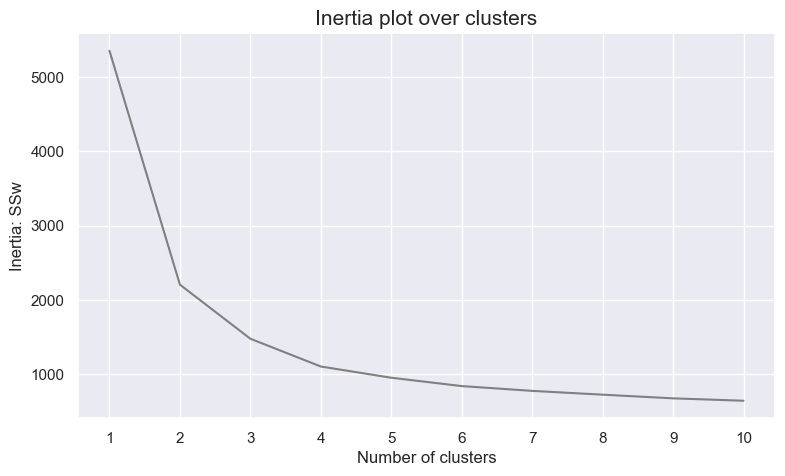

In [43]:
# Plot the inertia values to visualize the "elbow" point (optimal number of clusters)
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia, color='grey')
ax.set_xticks(range_clusters)
# Inertia represents the sum of squared distances to the nearest centroid
ax.set_ylabel("Inertia: SSw") 
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5288567384270683
For n_clusters = 3, the average silhouette_score is : 0.5021300855844901
For n_clusters = 4, the average silhouette_score is : 0.45139207784115565
For n_clusters = 5, the average silhouette_score is : 0.428732105998824
For n_clusters = 6, the average silhouette_score is : 0.392557456526076
For n_clusters = 7, the average silhouette_score is : 0.3940759331598119
For n_clusters = 8, the average silhouette_score is : 0.3748353649141877
For n_clusters = 9, the average silhouette_score is : 0.3535381685015485
For n_clusters = 10, the average silhouette_score is : 0.34663787304855664


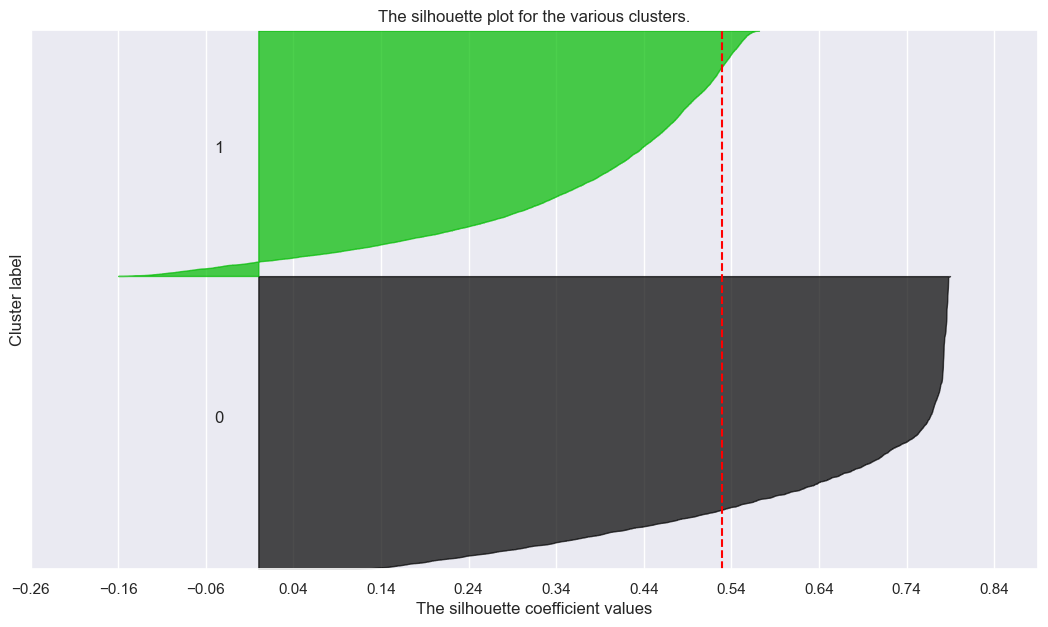

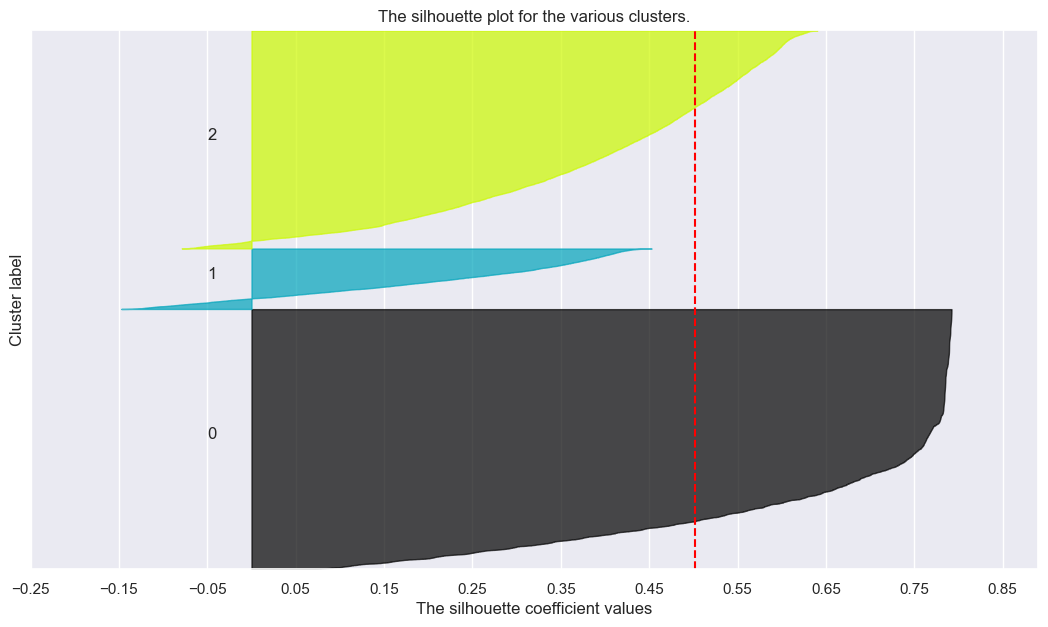

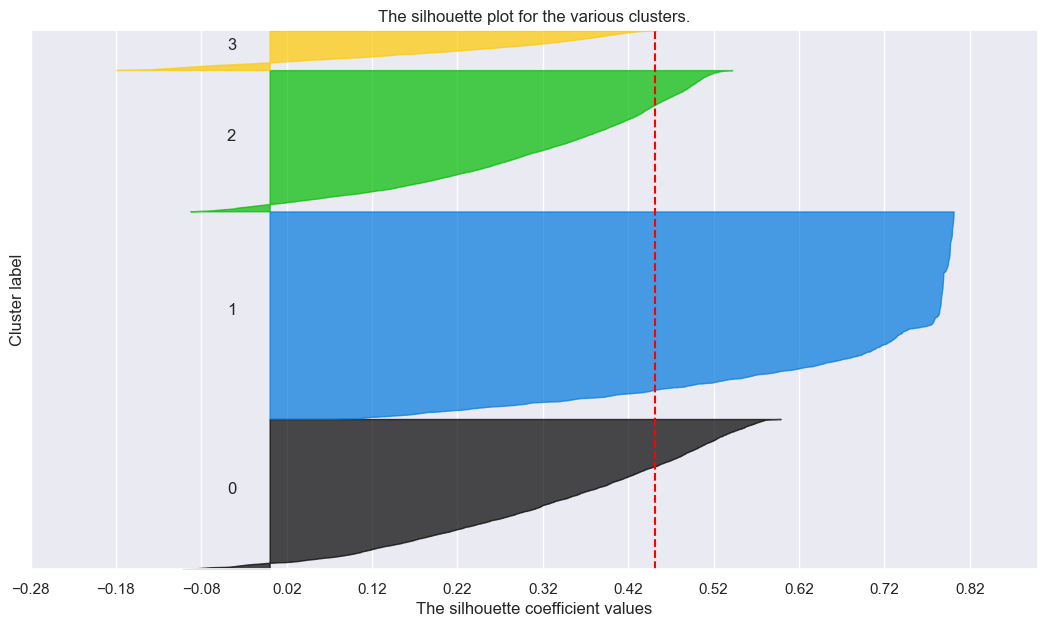

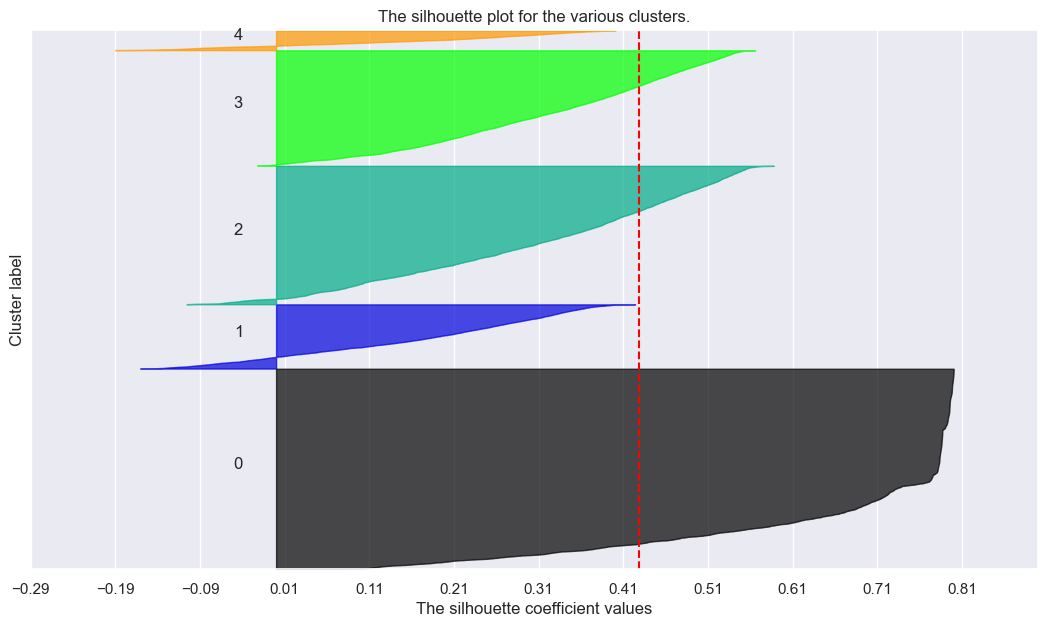

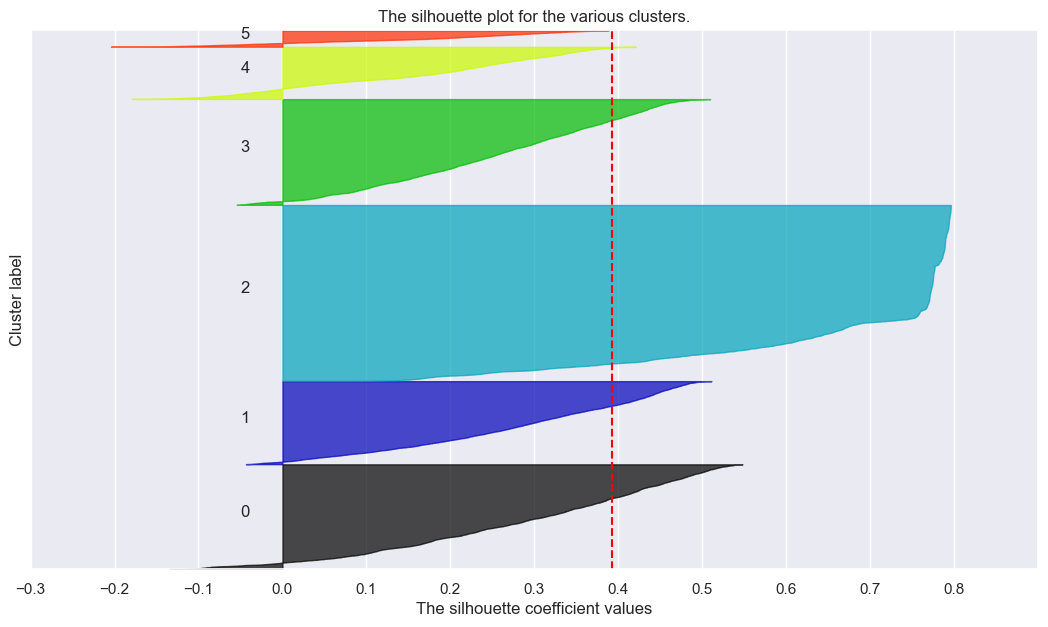

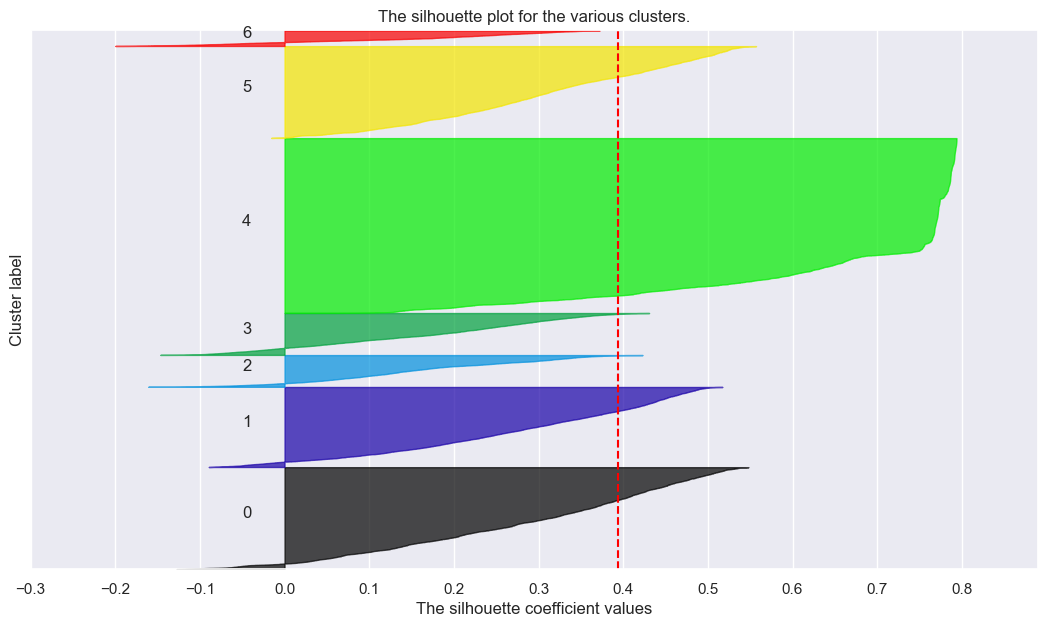

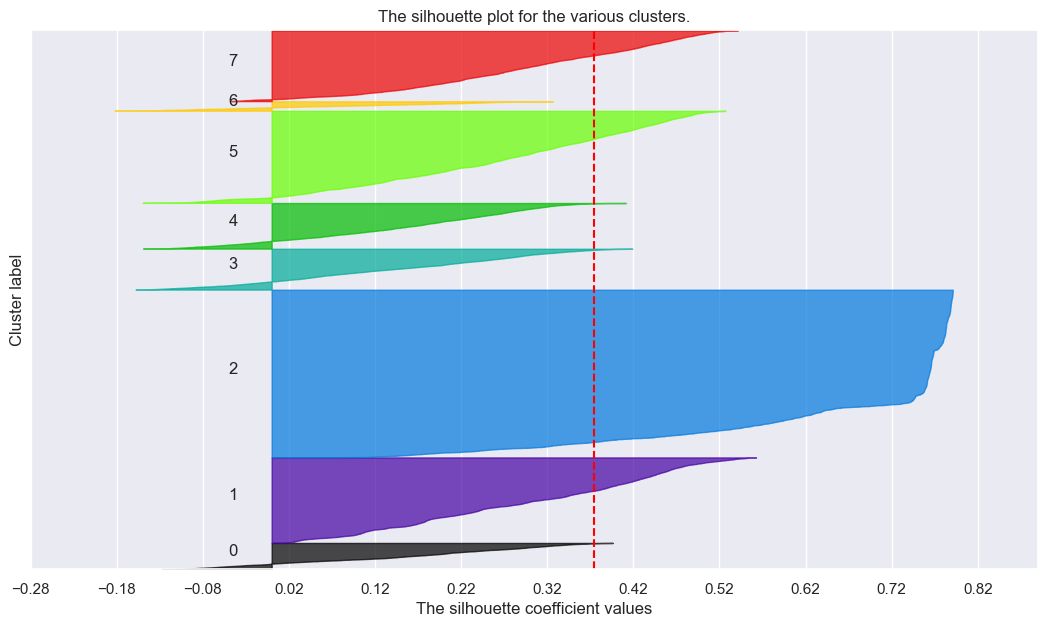

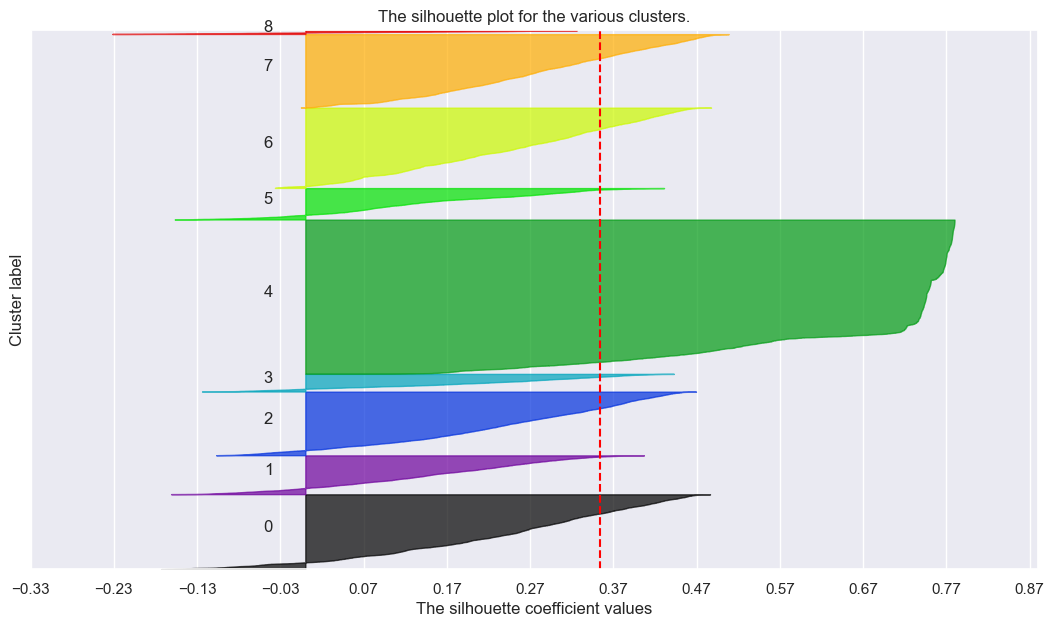

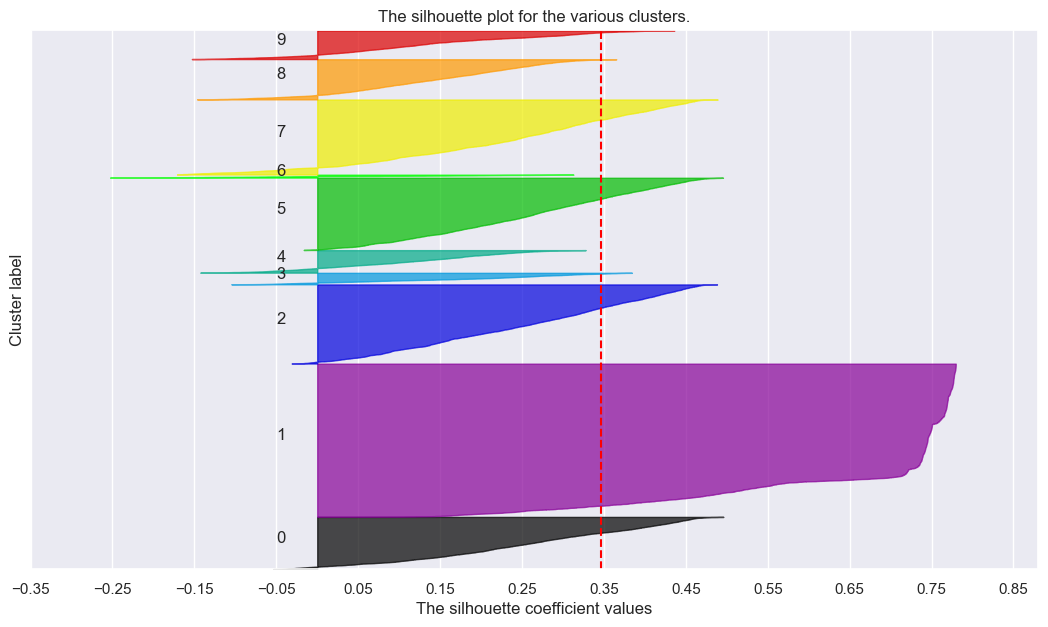

In [44]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Store average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # Seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Fill the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # Lots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    # Clear the yaxis labels / ticks
    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

<a class="anchor" id="16">     

## 3.3. Average Silhouette Score Against The Mumber of Clusters

</a>  

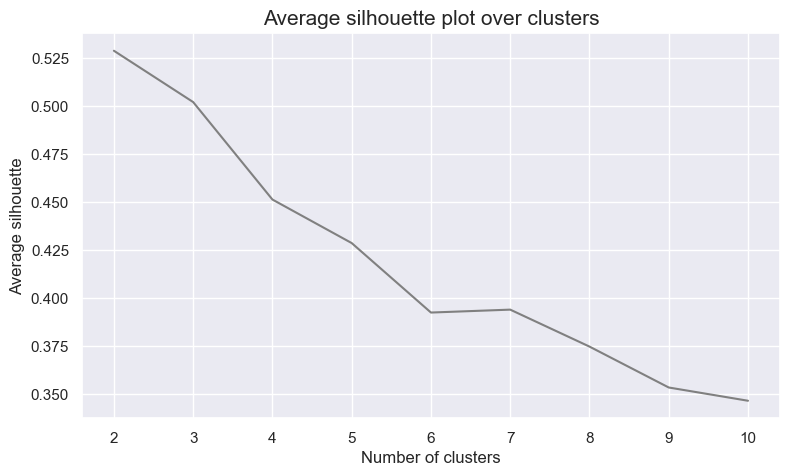

In [45]:
plt.figure(figsize=(9,5))

# Why range_clusters[1:] is because we skipped k=1 in the cell above 

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette,
         color = 'grey')     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

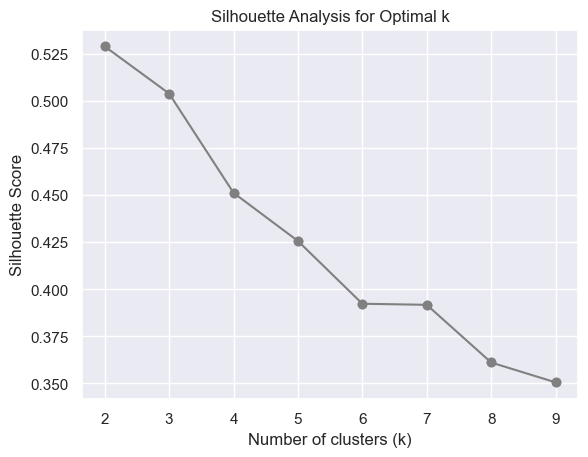

In [46]:
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df[metric_features])  # X is your data
    silhouette_avg = silhouette_score(df[metric_features], labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.plot(range(2, 10), silhouette_scores, marker='o', color='grey', label='Silhouette Score')
plt.scatter(range(2, 10), silhouette_scores, color='grey')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

As you can see from the graphs, that the optimal number of clusters is between 2 and 3. Additionally, as that was the optimal clusters from hierachical as well, that confirmed our choice for performing KMeans with 3 clusters as well.

<a class="anchor" id="17">     

## 3.4. Final K-Means Clustering Solution with 3 Clusters

</a> 

In [47]:
# Initialize the KMeans with the optimal number of clusters
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [48]:
# Characterize the final clusters by calculating the mean of each feature within each cluster
df_concat = pd.concat((df[metric_features], pd.Series(km_labels, name='labels', index=df.index)), axis=1)
# Group by cluster labels and calculate the mean of each feature
df_concat.groupby('labels').mean() 

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.051455,0.096746,0.025092,0.012482,0.011591,0.020655,0.012352,0.021765
1,0.588242,0.839532,0.139040,0.183226,0.093507,0.160084,0.108120,0.169372
2,0.171056,0.628002,0.049362,0.047697,0.027609,0.051237,0.028968,0.052188


<a class="anchor" id="18">     

# 4. Clustering by Perspectives

</a> 

In [49]:
# Customer Behavior Perspective
behavior_features = [
    'morning_orders',
    'afternoon_orders',
    'evening_orders',
    'weekend_orders',
    'vendor_count'
]

# Customer Value Perspective
value_features = [
    'total_orders',
    'days_as_customer',
    'money_spent'
]

df_behavior = df[behavior_features].copy()
df_value = df[value_features].copy()

<a class="anchor" id="19">     

## 4.1. Testing on K-means Clustering and Hierarchical Clustering

</a> 

Based on the elbow method, the optimal number of clusters is between 2 and 3.

In [50]:
# Set up the clusterers
kmeans = KMeans(
    # Use the k-means++ initialization to improve convergence
    init='k-means++', 
    # Number of initializations for k-means
    n_init=20, 
    # For reproducibility
    random_state=42 
)

hierarchical = AgglomerativeClustering(
    # Use Euclidean distance metric for hierarchical clustering
    metric='euclidean' 
)

In [51]:
def get_r2_scores(df, feats, clusterer, min_k=2, max_k=10):
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df, 
                               pd.Series(labels, name='labels', index=df.index)], axis=1)  

        r2_clust[n] = get_rsq(df_concat, feats, 'labels' )
    return r2_clust

<a class="anchor" id="20">     

## 4.2. Finding The Optimal Clusterer on Behavior Variables

</a> 

In [52]:
df_behavior[behavior_features]

,morning_orders,afternoon_orders,evening_orders,weekend_orders,vendor_count
0,0.000000,0.000000,0.066667,0.08,0.076923
1,0.044444,0.000000,0.000000,0.08,0.076923
2,0.044444,0.000000,0.000000,0.08,0.000000
3,0.022222,0.027027,0.000000,0.04,0.076923
4,0.044444,0.000000,0.000000,0.04,0.076923
...,...,...,...,...,...
31626,0.000000,0.000000,0.033333,0.00,0.000000
31627,0.000000,0.027027,0.000000,0.00,0.000000
31628,0.000000,0.027027,0.000000,0.00,0.000000
31629,0.000000,0.027027,0.000000,0.00,0.000000


In [53]:
# Obtaining the R² scores for each cluster solution on demographic variables
# This may take some time to run

r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_behavior, behavior_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_behavior,                 # data
        behavior_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )

In [54]:
r2_scores_behavior = pd.DataFrame(r2_scores)
r2_scores_behavior

,kmeans,complete,average,single,ward
2,0.537319,0.037033,0.039913,0.000911,0.475172
3,0.683328,0.115709,0.042368,0.002105,0.651668
4,0.741232,0.118764,0.043068,0.003588,0.715524
5,0.768030,0.121526,0.043700,0.005096,0.751490
6,0.784785,0.127147,0.046311,0.005796,0.766385
7,0.800415,0.441878,0.046458,0.006699,0.780514
8,0.813375,0.445888,0.490105,0.007309,0.791245
9,0.822405,0.446687,0.490446,0.009344,0.801753


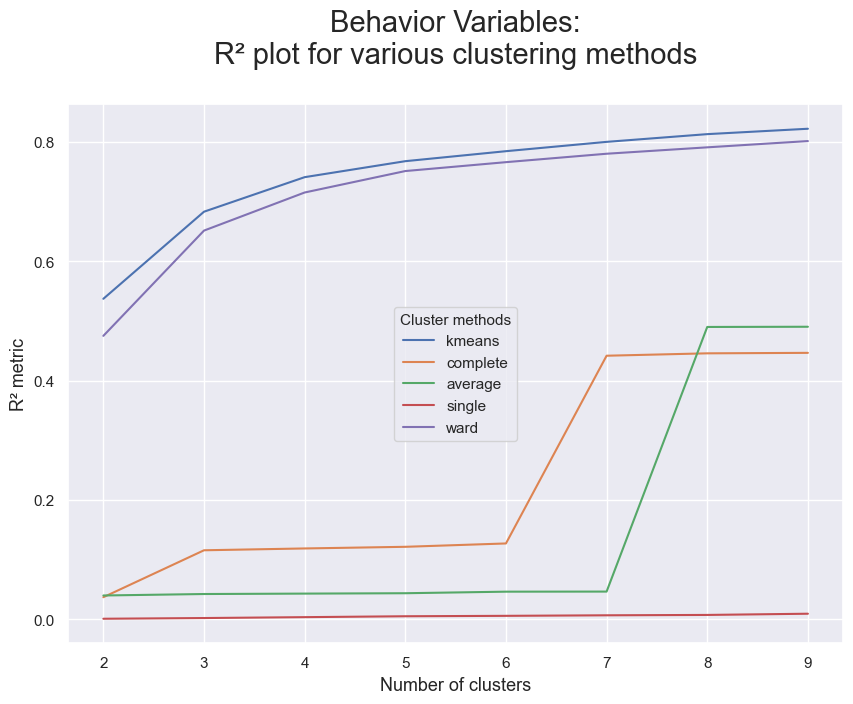

In [55]:
# Visualizing the R² scores for each cluster solution on behavior variables
r2_scores_behavior.plot.line(figsize=(10,7))

plt.title("Behavior Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

<a class="anchor" id="21">     

## 4.3. Finding The Optimal Clusterer on Value Variables

</a> 

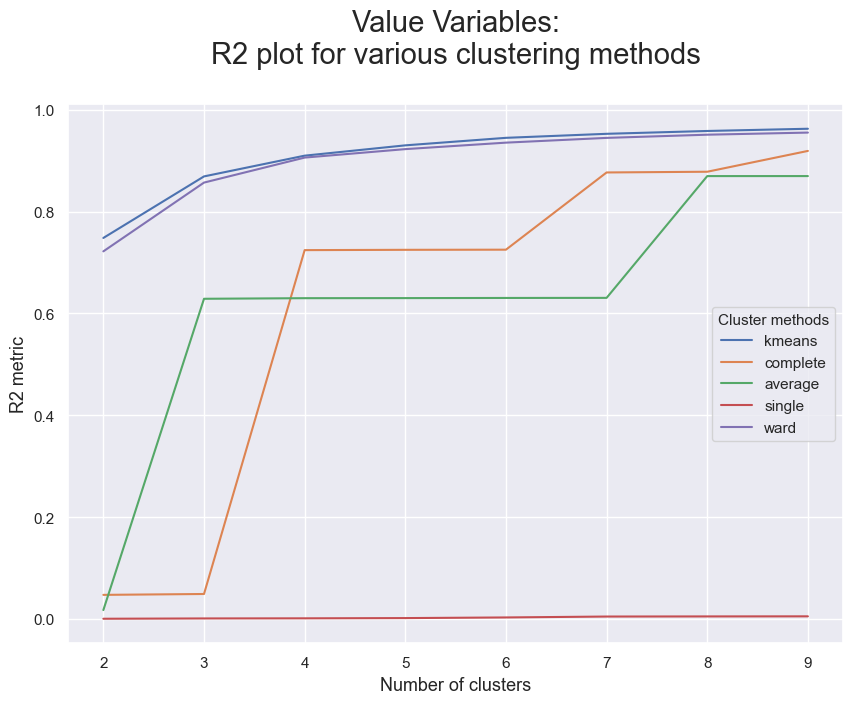

In [56]:
# Obtaining the R² scores for each cluster solution on value variables
r2_scores_value = {}
r2_scores_value['kmeans'] = get_r2_scores(df_value, value_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores_value[linkage] = get_r2_scores(
        df_value, value_features, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on value variables
pd.DataFrame(r2_scores_value).plot.line(figsize=(10,7))

plt.title("Value Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

<a class="anchor" id="22">     

## 4.4. Merging the Perspectives

</a> 

- How can we merge different cluster solutions?

In [57]:
# Apply the right clustering (algorithm and number of clusters) for each perspective
kmeans_value = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(df_value)

kmeans_behavior = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behavior.fit_predict(df_behavior)

df['value_labels'] = value_labels
df['behavior_labels'] = behavior_labels

In [58]:
# Count label frequencies (contigency table)

pd.crosstab(df['behavior_labels'],
            df['value_labels'])

value_labels,0,1,2
behavior_labels,,,
0,2486,342,4485
1,6834,12449,3236
2,122,7,1670


<a class="anchor" id="23">     

## 4.5. Manual Merging: Merge Lowest Frequency Clusters into Closest Clusters

</a> 

In [82]:
# Get centroids of clusters
df_centroids = df.groupby(['behavior_labels', 'value_labels'])\
    [metric_features].mean()


df_centroids

vendor_count  days_as_customer  money_spent  \
behavior_labels value_labels                                                
0               0                 0.291262          0.475534     0.061984   
                1                 0.266982          0.160884     0.053851   
                2                 0.329114          0.805921     0.084566   
1               0                 0.095552          0.435083     0.034053   
                1                 0.035313          0.053110     0.022624   
                2                 0.104260          0.775299     0.044081   
2               0                 0.679067          0.480874     0.120303   
                1                 0.758242          0.130159     0.093695   
                2                 0.751912          0.866075     0.170653   

                              total_orders  morning_orders  afternoon_orders  \
behavior_labels value_labels                                                   
0               0                 0.064708        0.037561          0.057587   
                1                 0.053343        0.030019          0.047653   
                2                 0.094354        0.049924          0.088825   
1               0                 0.027363        0.017504          0.034842   
                1                 0.008561        0.009895          0.017542   
                2                 0.040854        0.024619          0.050471   
2               0                 0.162494        0.077231          0.139123   
                1                 0.158301        0.095238          0.173745   
                2                 0.241374        0.121277          0.206134   

                              evening_orders  weekend_orders  
behavior_labels value_labels                                  
0               0                   0.040641        0.068624  
                1                   0.035088        0.056257  
                2                   0.052427        0.089757  
1               0                   0.019291        0.034960  
                1                   0.010322        0.018424  
                2                   0.022198        0.045093  
2               0                   0.121311        0.155738  
                1                   0.066667        0.177143  
                2                   0.148483        0.224766

In [83]:
# Clusters with low frequency to be merged: (behavior_label, value_label)
to_merge = [(1,0), (1,1), (3,0), (3,1)]

In [84]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

behavior_labels                          0                                 1  \
value_labels                             0         1             2         0   
behavior_labels value_labels                                                   
0               0             1.053671e-08  0.316432  3.371812e-01  0.211240   
                1             3.164318e-01  0.000000  6.527427e-01  0.326595   
                2             3.371812e-01  0.652743  1.490116e-08  0.455168   
1               0             2.112400e-01  0.326595  4.551676e-01  0.000000   
                1             5.044421e-01  0.267623  8.232771e-01  0.388236   
                2             3.561323e-01  0.636053  2.470193e-01  0.341338   
2               0             4.309323e-01  0.562552  4.964038e-01  0.638532   
                1             6.135083e-01  0.539118  8.136840e-01  0.775007   
                2             6.876222e-01  0.925283  5.076506e-01  0.879687   

behavior_labels                                              2            \
value_labels                         1             2         0         1   
behavior_labels value_labels                                               
0               0             0.504442  3.561323e-01  0.430932  0.613508   
                1             0.267623  6.360531e-01  0.562552  0.539118   
                2             0.823277  2.470193e-01  0.496404  0.813684   
1               0             0.388236  3.413375e-01  0.638532  0.775007   
                1             0.000000  7.279881e-01  0.825304  0.784911   
                2             0.727988  1.490116e-08  0.685849  0.948552   
2               0             0.825304  6.858485e-01  0.000000  0.367373   
                1             0.784911  9.485525e-01  0.367373  0.000000   
                2             1.166266  7.521478e-01  0.417584  0.751748   

behavior_labels                         
value_labels                         2  
behavior_labels value_labels            
0               0             0.687622  
                1             0.925283  
                2             0.507651  
1               0             0.879687  
                1             1.166266  
                2             0.752148  
2               0             0.417584  
                1             0.751748  
                2             0.000000

In [ ]:
#Merging each low frequency clustering (source) to the closest cluster (target)

source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

In [77]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['value_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'value_labels'] = target[1]

In [78]:
# New contigency table

pd.crosstab(df_['behavior_labels'],
            df_['value_labels'])

value_labels,0,1,2
behavior_labels,,,
0,9320,12791,4485
1,0,0,3236
2,122,7,1670


In [ ]:
# Get centroids of clusters
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()


df_centroids

In [80]:
to_merge = [(3,1), (3,2), (2,1), (0,2)]

In [81]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

behavior_labels                          0                                 1  \
value_labels                             0         1             2         0   
behavior_labels value_labels                                                   
0               0             1.053671e-08  0.316432  3.371812e-01  0.211240   
                1             3.164318e-01  0.000000  6.527427e-01  0.326595   
                2             3.371812e-01  0.652743  1.490116e-08  0.455168   
1               0             2.112400e-01  0.326595  4.551676e-01  0.000000   
                1             5.044421e-01  0.267623  8.232771e-01  0.388236   
                2             3.561323e-01  0.636053  2.470193e-01  0.341338   
2               0             4.309323e-01  0.562552  4.964038e-01  0.638532   
                1             6.135083e-01  0.539118  8.136840e-01  0.775007   
                2             6.876222e-01  0.925283  5.076506e-01  0.879687   

behavior_labels                                              2            \
value_labels                         1             2         0         1   
behavior_labels value_labels                                               
0               0             0.504442  3.561323e-01  0.430932  0.613508   
                1             0.267623  6.360531e-01  0.562552  0.539118   
                2             0.823277  2.470193e-01  0.496404  0.813684   
1               0             0.388236  3.413375e-01  0.638532  0.775007   
                1             0.000000  7.279881e-01  0.825304  0.784911   
                2             0.727988  1.490116e-08  0.685849  0.948552   
2               0             0.825304  6.858485e-01  0.000000  0.367373   
                1             0.784911  9.485525e-01  0.367373  0.000000   
                2             1.166266  7.521478e-01  0.417584  0.751748   

behavior_labels                         
value_labels                         2  
behavior_labels value_labels            
0               0             0.687622  
                1             0.925283  
                2             0.507651  
1               0             0.879687  
                1             1.166266  
                2             0.752148  
2               0             0.417584  
                1             0.751748  
                2             0.000000

<a class="anchor" id="24">     

## 4.6. Merging Using Hierarchical Clustering

</a> 

In [86]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'value_labels'])\
    [metric_features].mean()
df_centroids

vendor_count  days_as_customer  money_spent  \
behavior_labels value_labels                                                
0               0                 0.291262          0.475534     0.061984   
                1                 0.266982          0.160884     0.053851   
                2                 0.329114          0.805921     0.084566   
1               0                 0.095552          0.435083     0.034053   
                1                 0.035313          0.053110     0.022624   
                2                 0.104260          0.775299     0.044081   
2               0                 0.679067          0.480874     0.120303   
                1                 0.758242          0.130159     0.093695   
                2                 0.751912          0.866075     0.170653   

                              total_orders  morning_orders  afternoon_orders  \
behavior_labels value_labels                                                   
0               0                 0.064708        0.037561          0.057587   
                1                 0.053343        0.030019          0.047653   
                2                 0.094354        0.049924          0.088825   
1               0                 0.027363        0.017504          0.034842   
                1                 0.008561        0.009895          0.017542   
                2                 0.040854        0.024619          0.050471   
2               0                 0.162494        0.077231          0.139123   
                1                 0.158301        0.095238          0.173745   
                2                 0.241374        0.121277          0.206134   

                              evening_orders  weekend_orders  
behavior_labels value_labels                                  
0               0                   0.040641        0.068624  
                1                   0.035088        0.056257  
                2                   0.052427        0.089757  
1               0                   0.019291        0.034960  
                1                   0.010322        0.018424  
                2                   0.022198        0.045093  
2               0                   0.121311        0.155738  
                1                   0.066667        0.177143  
                2                   0.148483        0.224766

In [87]:
# Use Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

In [88]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # Track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# The hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# The hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# The counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 2.3
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k',
           link_color_func = '#404040')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

TypeError: 'str' object is not callable

<Figure size 1100x500 with 0 Axes>

In [89]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

# Centroid's cluster labels
df_centroids  

vendor_count  days_as_customer  money_spent  \
behavior_labels value_labels                                                
0               0                 0.291262          0.475534     0.061984   
                1                 0.266982          0.160884     0.053851   
                2                 0.329114          0.805921     0.084566   
1               0                 0.095552          0.435083     0.034053   
                1                 0.035313          0.053110     0.022624   
                2                 0.104260          0.775299     0.044081   
2               0                 0.679067          0.480874     0.120303   
                1                 0.758242          0.130159     0.093695   
                2                 0.751912          0.866075     0.170653   

                              total_orders  morning_orders  afternoon_orders  \
behavior_labels value_labels                                                   
0               0                 0.064708        0.037561          0.057587   
                1                 0.053343        0.030019          0.047653   
                2                 0.094354        0.049924          0.088825   
1               0                 0.027363        0.017504          0.034842   
                1                 0.008561        0.009895          0.017542   
                2                 0.040854        0.024619          0.050471   
2               0                 0.162494        0.077231          0.139123   
                1                 0.158301        0.095238          0.173745   
                2                 0.241374        0.121277          0.206134   

                              evening_orders  weekend_orders  hclust_labels  
behavior_labels value_labels                                                 
0               0                   0.040641        0.068624              1  
                1                   0.035088        0.056257              2  
                2                   0.052427        0.089757              1  
1               0                   0.019291        0.034960              1  
                1                   0.010322        0.018424              2  
                2                   0.022198        0.045093              1  
2               0                   0.121311        0.155738              0  
                1                   0.066667        0.177143              0  
                2                   0.148483        0.224766              0

In [90]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 1,
 (0, 1): 2,
 (0, 2): 1,
 (1, 0): 1,
 (1, 1): 2,
 (1, 2): 1,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 0}

In [91]:
df_ = df.copy()

# Map the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['value_labels'])
    ], axis=1
)

df_ 

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,afternoon_orders,evening_orders,customer_frequency,customer_preference,weekend_orders,value_labels,behavior_labels,merged_labels
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,0.000000,0.066667,Infrequent,CUI_Indian,0.08,1,1,2
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08,1,1,2
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08,1,1,2
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,0.027027,0.000000,Infrequent,CUI_Indian,0.04,1,1,2
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,0.000000,0.000000,Infrequent,CUI_Asian,0.04,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31626,eb13c834e7,0.000000,True,CARD,0.000000,0.001726,City A,0.000000,Senior,0.000000,0.000000,0.033333,Infrequent,CUI_Chicken Dishes,0.00,1,1,2
31627,f7be3a1a84,0.000000,True,CASH,0.000000,0.001863,City A,0.000000,Young Adult,0.000000,0.027027,0.000000,Infrequent,CUI_Italian,0.00,1,1,2
31628,fc924e1758,0.000000,False,CASH,0.000000,0.028488,City B,0.000000,Young Adult,0.000000,0.027027,0.000000,Infrequent,CUI_OTHER,0.00,1,1,2
31629,fcdbf7468b,0.000000,True,CARD,0.000000,0.027063,City B,0.000000,Young Adult,0.000000,0.027027,0.000000,Infrequent,CUI_OTHER,0.00,1,1,2


In [92]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
merged_labels,,,,,,,,
0,0.746996,0.837089,0.166939,0.235702,0.118189,0.201463,0.146322,0.219900
1,0.187227,0.603190,0.053327,0.053004,0.030314,0.055336,0.031679,0.056217
2,0.041508,0.055992,0.023459,0.009759,0.010433,0.018347,0.010984,0.019436


In [93]:
# Merge cluster contigency table
# Get size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

,0
merged_labels,
0,1799
1,17041
2,12791


In [94]:
# Get the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

,merged_labels,0
0,"(2, 2)",1799
1,"(1, 2)",17041
2,"(1, 1)",12791


In [95]:
df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['value_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

,merged_labels,0,behavior_labels,value_labels
0,"(2, 2)",1799,2,2
1,"(1, 2)",17041,1,2
2,"(1, 1)",12791,1,1


In [96]:
df_counts.pivot(values=0, index='behavior_labels', columns='value_labels')

value_labels,1,2
behavior_labels,,
1,12791.0,17041.0
2,NaN,1799.0


In [97]:
# Set df to have the final product, behavior and merged clusters
df = df_.copy()

<a class="anchor" id="25">     

# 5. Cluster Analysis

</a> 

In [98]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="Greys",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

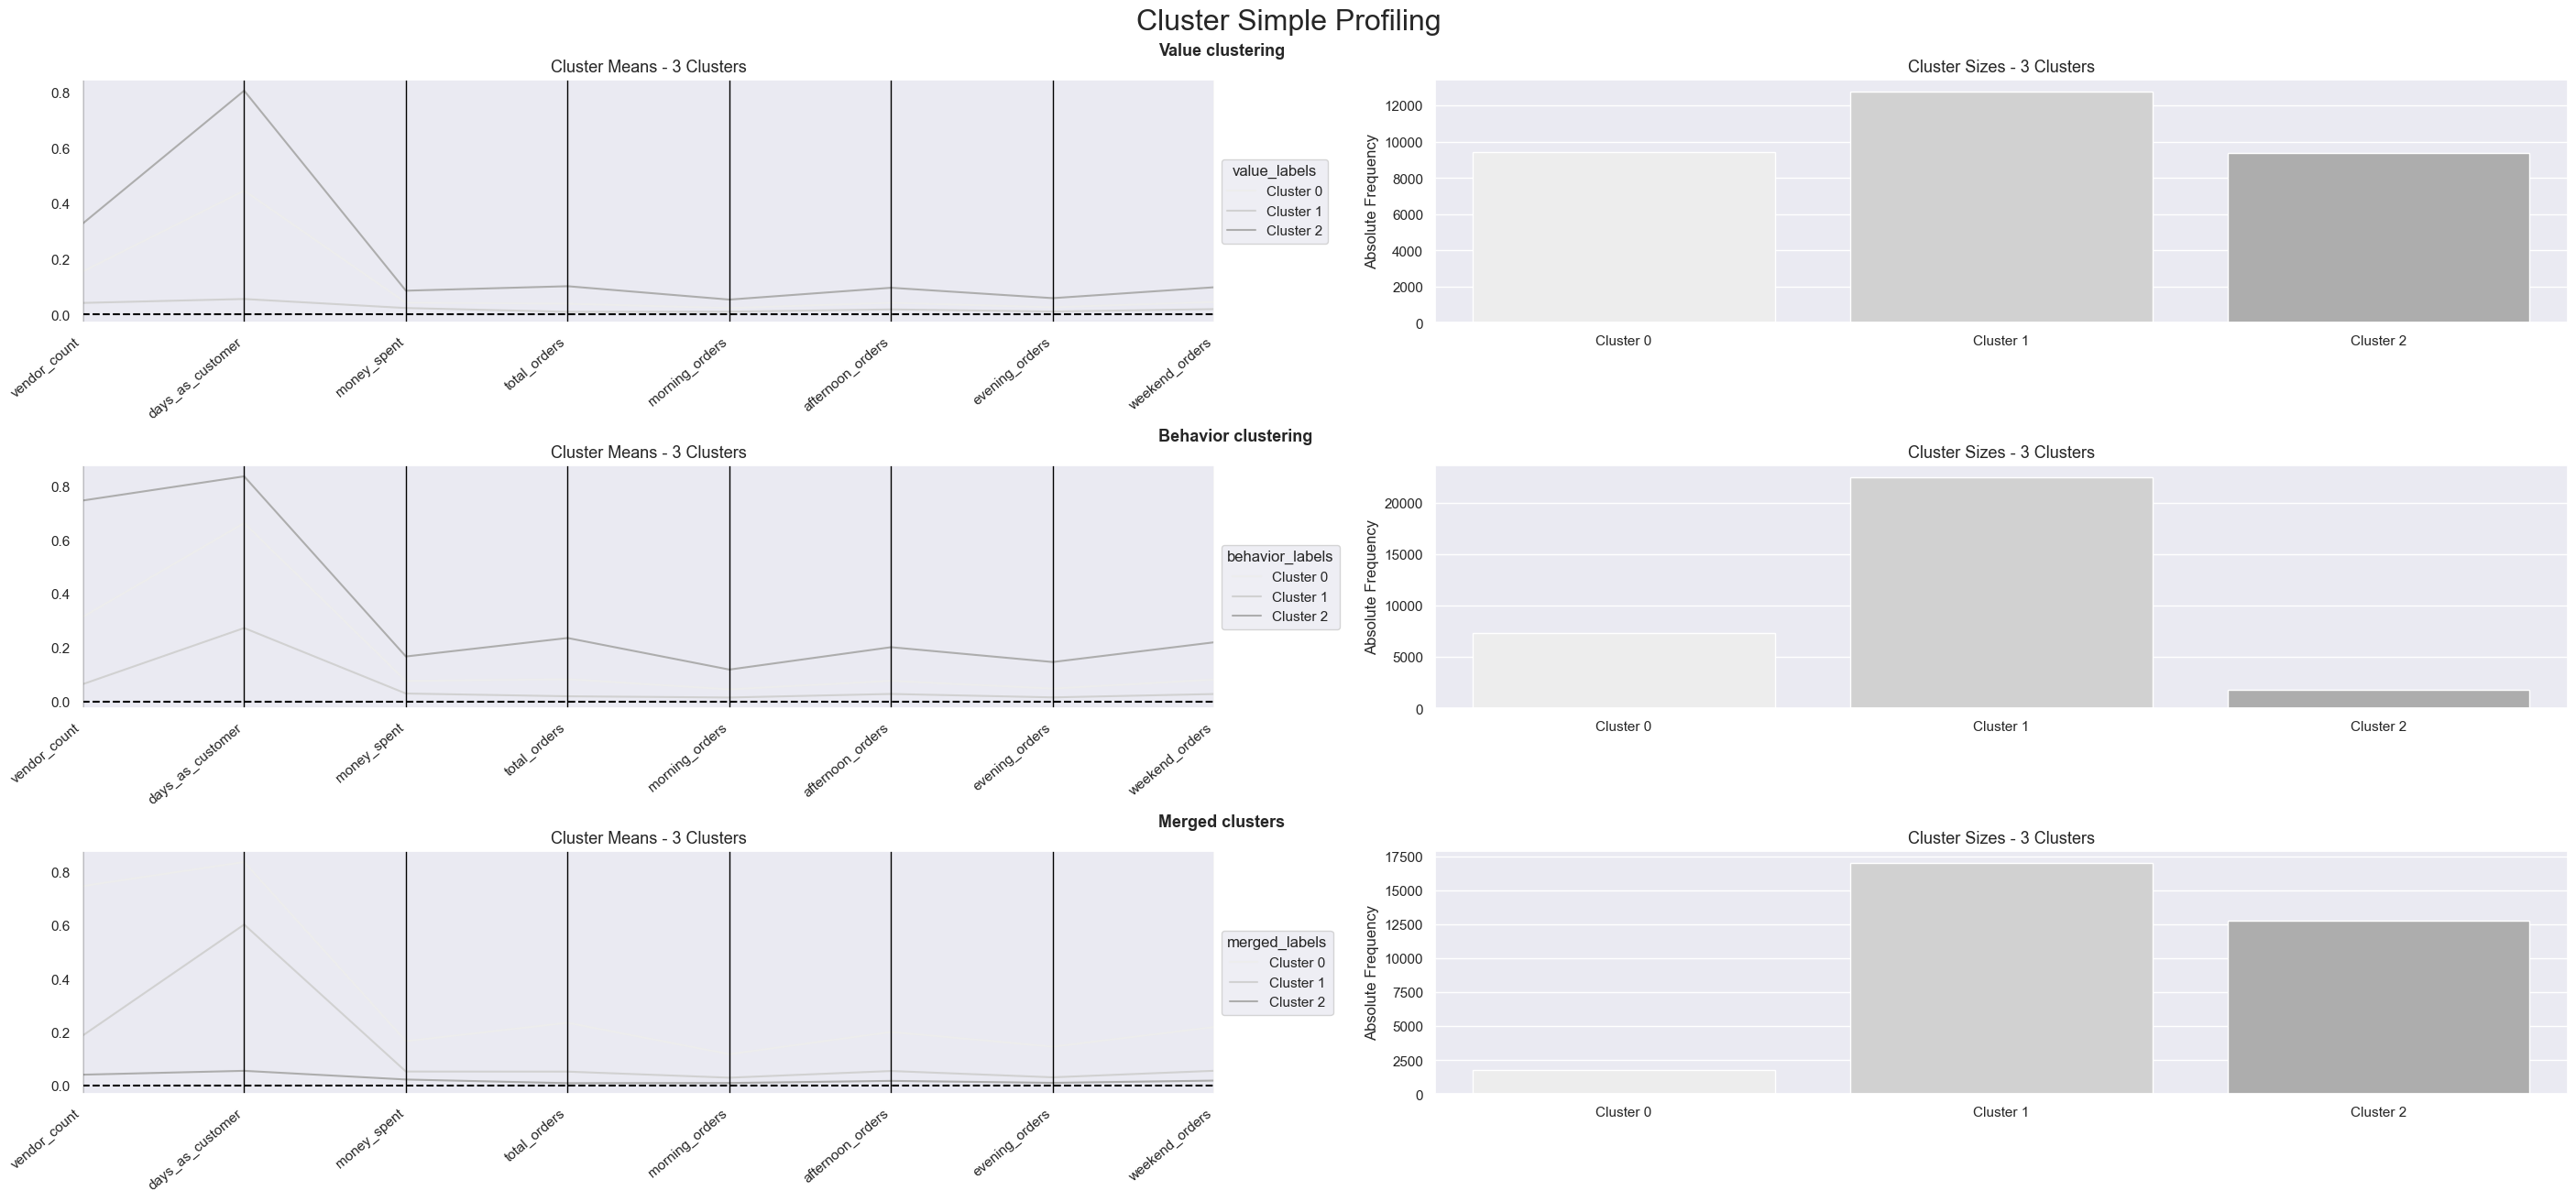

In [99]:
# Profilling each cluster (value, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['value_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Behavior clustering", "Merged clusters"]
)

<a class="anchor" id="26">     

## 5.1. Profiling with Unused / Categorical Features

</a> 

In [100]:
non_metric_features

['is_chain',
 'payment_method',
 'customer_city',
 'age_group',
 'customer_frequency',
 'customer_preference']

In [101]:
# Create dummy variables for the merged_cluster column
dummy_encoded_clusters = pd.get_dummies(df['age_group'])

# Append the dummy variables to the original DataFrame (optional)
df = pd.concat([df, dummy_encoded_clusters], axis=1)

df

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,...,customer_frequency,customer_preference,weekend_orders,value_labels,behavior_labels,merged_labels,Adult,Child,Senior,Young Adult
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,...,Infrequent,CUI_Indian,0.08,1,1,2,False,False,False,True
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,...,Infrequent,CUI_American,0.08,1,1,2,False,True,False,False
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,...,Infrequent,CUI_American,0.08,1,1,2,True,False,False,False
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,...,Infrequent,CUI_Indian,0.04,1,1,2,False,False,False,True
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,...,Infrequent,CUI_Asian,0.04,1,1,2,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31626,eb13c834e7,0.000000,True,CARD,0.000000,0.001726,City A,0.000000,Senior,0.000000,...,Infrequent,CUI_Chicken Dishes,0.00,1,1,2,False,False,True,False
31627,f7be3a1a84,0.000000,True,CASH,0.000000,0.001863,City A,0.000000,Young Adult,0.000000,...,Infrequent,CUI_Italian,0.00,1,1,2,False,False,False,True
31628,fc924e1758,0.000000,False,CASH,0.000000,0.028488,City B,0.000000,Young Adult,0.000000,...,Infrequent,CUI_OTHER,0.00,1,1,2,False,False,False,True
31629,fcdbf7468b,0.000000,True,CARD,0.000000,0.027063,City B,0.000000,Young Adult,0.000000,...,Infrequent,CUI_OTHER,0.00,1,1,2,False,False,False,True


In [102]:

# Create dummy variables for the merged_cluster column
dummy_encoded_clusters = pd.get_dummies(df['customer_city'])

# Append the dummy variables to the original DataFrame (optional)
df = pd.concat([df, dummy_encoded_clusters], axis=1)

df

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,...,value_labels,behavior_labels,merged_labels,Adult,Child,Senior,Young Adult,City A,City B,City C
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,...,1,1,2,False,False,False,True,True,False,False
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,...,1,1,2,False,True,False,False,False,False,True
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,...,1,1,2,True,False,False,False,False,True,False
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,...,1,1,2,False,False,False,True,False,True,False
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,...,1,1,2,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31626,eb13c834e7,0.000000,True,CARD,0.000000,0.001726,City A,0.000000,Senior,0.000000,...,1,1,2,False,False,True,False,True,False,False
31627,f7be3a1a84,0.000000,True,CASH,0.000000,0.001863,City A,0.000000,Young Adult,0.000000,...,1,1,2,False,False,False,True,True,False,False
31628,fc924e1758,0.000000,False,CASH,0.000000,0.028488,City B,0.000000,Young Adult,0.000000,...,1,1,2,False,False,False,True,False,True,False
31629,fcdbf7468b,0.000000,True,CARD,0.000000,0.027063,City B,0.000000,Young Adult,0.000000,...,1,1,2,False,False,False,True,False,True,False


In [103]:
# Create dummy variables for the merged_cluster column
dummy_encoded_clusters = pd.get_dummies(df['customer_preference'], prefix='cluster')

# Append the dummy variables to the original DataFrame (optional)
df = pd.concat([df, dummy_encoded_clusters], axis=1)

df

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,...,cluster_CUI_Chinese,cluster_CUI_Desserts,cluster_CUI_Healthy,cluster_CUI_Indian,cluster_CUI_Italian,cluster_CUI_Japanese,cluster_CUI_Noodle Dishes,cluster_CUI_OTHER,cluster_CUI_Street Food / Snacks,cluster_CUI_Thai
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,...,False,False,False,True,False,False,False,False,False,False
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,...,False,False,False,False,False,False,False,False,False,False
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,...,False,False,False,False,False,False,False,False,False,False
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,...,False,False,False,True,False,False,False,False,False,False
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31626,eb13c834e7,0.000000,True,CARD,0.000000,0.001726,City A,0.000000,Senior,0.000000,...,False,False,False,False,False,False,False,False,False,False
31627,f7be3a1a84,0.000000,True,CASH,0.000000,0.001863,City A,0.000000,Young Adult,0.000000,...,False,False,False,False,True,False,False,False,False,False
31628,fc924e1758,0.000000,False,CASH,0.000000,0.028488,City B,0.000000,Young Adult,0.000000,...,False,False,False,False,False,False,False,True,False,False
31629,fcdbf7468b,0.000000,True,CARD,0.000000,0.027063,City B,0.000000,Young Adult,0.000000,...,False,False,False,False,False,False,False,True,False,False


In [104]:
df.columns

Index(['customer_id', 'vendor_count', 'is_chain', 'payment_method',
       'days_as_customer', 'money_spent', 'customer_city', 'total_orders',
       'age_group', 'morning_orders', 'afternoon_orders', 'evening_orders',
       'customer_frequency', 'customer_preference', 'weekend_orders',
       'value_labels', 'behavior_labels', 'merged_labels', 'Adult', 'Child',
       'Senior', 'Young Adult', 'City A', 'City B', 'City C',
       'cluster_CUI_American', 'cluster_CUI_Asian', 'cluster_CUI_Beverages',
       'cluster_CUI_Cafe', 'cluster_CUI_Chicken Dishes', 'cluster_CUI_Chinese',
       'cluster_CUI_Desserts', 'cluster_CUI_Healthy', 'cluster_CUI_Indian',
       'cluster_CUI_Italian', 'cluster_CUI_Japanese',
       'cluster_CUI_Noodle Dishes', 'cluster_CUI_OTHER',
       'cluster_CUI_Street Food / Snacks', 'cluster_CUI_Thai'],
      dtype='object')

In [105]:
df_city = df[[
    'merged_labels',
    'City A',
    'City B',
    'City C'
    ]].groupby(['merged_labels']).sum()

df_city

,City A,City B,City C
merged_labels,,,
0,1011,433,355
1,5830,5813,5398
2,3888,4134,4769


In [106]:
df_age = df[[
    'merged_labels',
    'Child',
    'Young Adult',
    'Adult',
    'Senior'
    ]].groupby(['merged_labels']).sum()

df_age

,Child,Young Adult,Adult,Senior
merged_labels,,,,
0,17,1526,246,10
1,190,14512,2298,41
2,156,10869,1733,33


In [107]:
df_preference = df[[
    'merged_labels',
    'cluster_CUI_American',
    'cluster_CUI_Asian',
    'cluster_CUI_Beverages',
    'cluster_CUI_Cafe',
    'cluster_CUI_Chicken Dishes',
    'cluster_CUI_Chinese',
    'cluster_CUI_Desserts',
    'cluster_CUI_Healthy',
    'cluster_CUI_Indian',
    'cluster_CUI_Italian',
    'cluster_CUI_Japanese',
    'cluster_CUI_Noodle Dishes',
    'cluster_CUI_OTHER',
    'cluster_CUI_Street Food / Snacks',
    'cluster_CUI_Thai'
     ]].groupby(['merged_labels']).sum()

df_preference

,cluster_CUI_American,cluster_CUI_Asian,cluster_CUI_Beverages,cluster_CUI_Cafe,cluster_CUI_Chicken Dishes,cluster_CUI_Chinese,cluster_CUI_Desserts,cluster_CUI_Healthy,cluster_CUI_Indian,cluster_CUI_Italian,cluster_CUI_Japanese,cluster_CUI_Noodle Dishes,cluster_CUI_OTHER,cluster_CUI_Street Food / Snacks,cluster_CUI_Thai
merged_labels,,,,,,,,,,,,,,,
0,165,406,93,60,84,131,26,32,113,100,108,89,284,69,39
1,2309,3801,1036,259,636,715,268,409,876,1725,1224,487,1689,1174,433
2,1676,2793,922,168,409,481,324,281,695,1226,1044,307,1151,1036,278


In [108]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0     1799
1    17041
2    12791
Name: count, dtype: int64

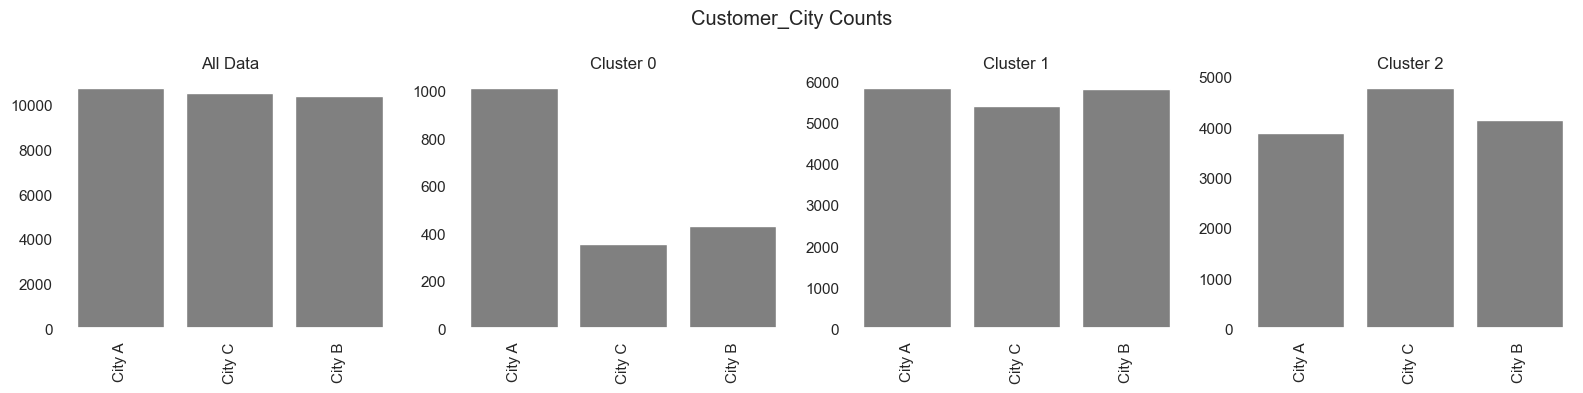

In [109]:
fig, axes = plt.subplots(
    1, 
    df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
    figsize=(16, 4),
    tight_layout=True
)

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(df, 
                      x='customer_city', 
                      order=df['customer_city'].value_counts().index,
                      ax=ax,
                      color = 'grey')
        ax.set_title("All Data")
    else:    
        sns.countplot(df.loc[df['merged_labels'] == i - 1], 
                      x='customer_city', 
                      order=df['customer_city'].value_counts().index,
                      ax=ax,
                      color = 'grey')
        ax.set_title("Cluster {}".format(i - 1))
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_facecolor('white')  # Set the background color of each subplot to white

plt.suptitle("Customer_City Counts", )
plt.show()

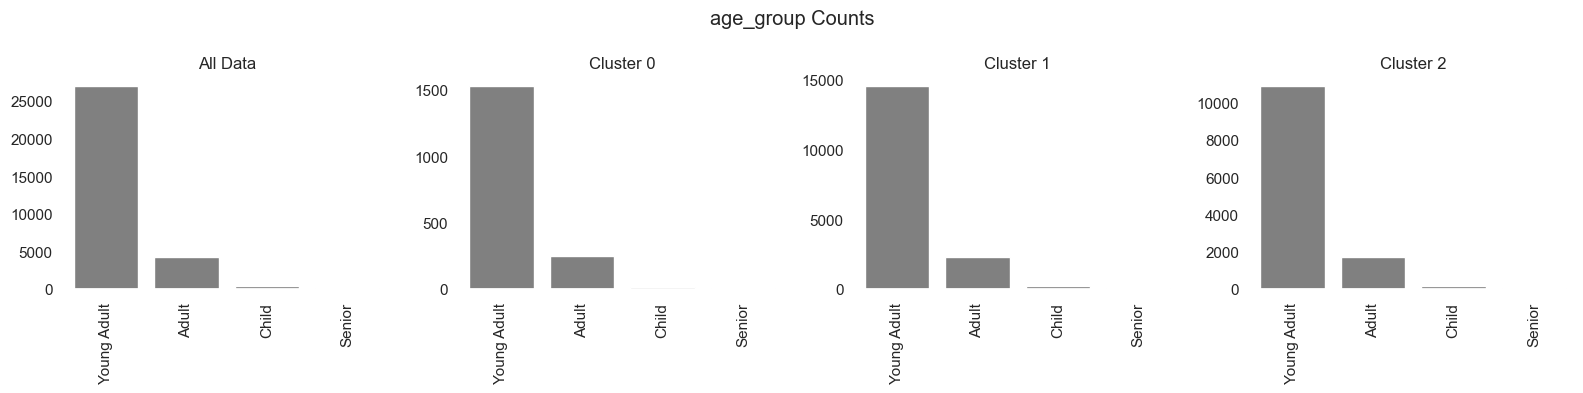

In [110]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16,4),
                         tight_layout=True,
                        #  sharey=True,
                         )


for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(df, 
                        x='age_group', 
                        order = df['age_group'].value_counts().index,
                        ax=ax,
                        color = 'grey')
        ax.set_title("All Data")
        
    else:    
        sns.countplot(df.loc[df['merged_labels']==i-1], 
                    x='age_group', 
                    order = df['age_group'].value_counts().index,
                    ax=ax,
                    color = 'grey')
        ax.set_title("Cluster {}".format(i-1))
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_facecolor('white')  # Set the background color of each subplot to white

plt.suptitle("age_group Counts", )
plt.show()

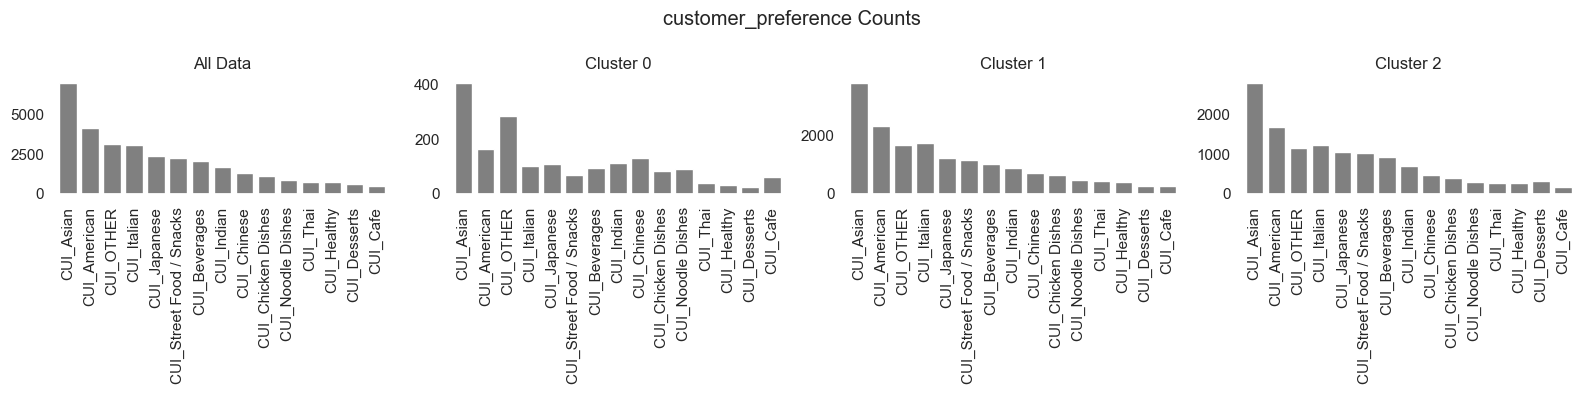

In [111]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16,4),
                         tight_layout=True,
                        #  sharey=True,
                         )


for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(df, 
                        x='customer_preference', 
                        order = df['customer_preference'].value_counts().index,
                        ax=ax,
                    color = 'grey'
                    )
        ax.set_title("All Data")
        
    else:    
        sns.countplot(df.loc[df['merged_labels']==i-1], 
                    x='customer_preference', 
                    order = df['customer_preference'].value_counts().index,
                    ax=ax,
                    color = 'grey'
                    )
        
        ax.set_title("Cluster {}".format(i-1))
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_facecolor('white')  # Set the background color of each subplot to white

plt.suptitle("customer_preference Counts", )
plt.show()

<a class="anchor" id="27">     

## 5.2. Cluster visualization using t-SNE

</a> 

In [112]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

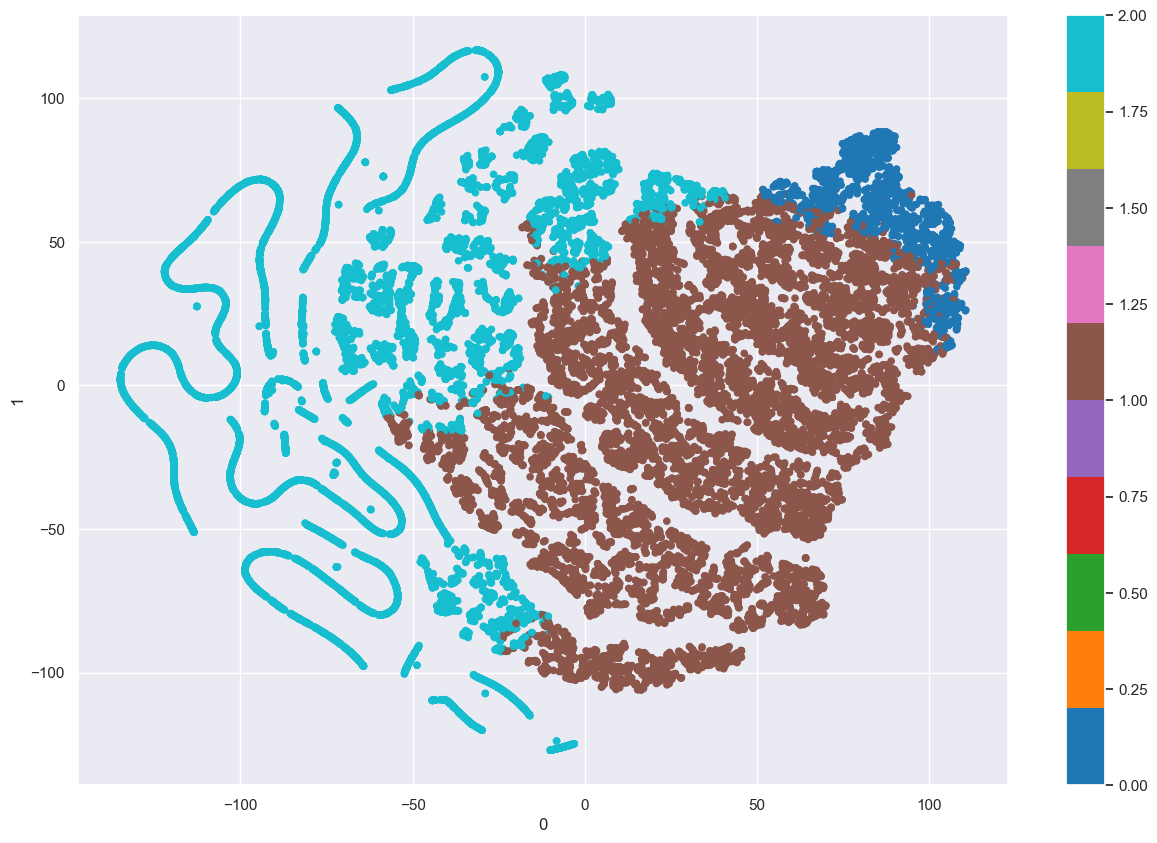

In [113]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()